# 🔋 Phase 4: Validasi Metode Coulomb Counting (Metode Konvensional)
**Tujuan:** Menghitung State of Charge (SoC) menggunakan metode integrasi arus (Ampere-Hour Counting / Coulomb Counting) pada data HPPC dan Dynamic Load.

**Rumus Utama:**
$$SoC(t) = SoC(t-1) - \frac{I(t) \times \Delta t}{Q_{total}}$$

**Kelemahan Metode Ini (Untuk dibahas di Skripsi):**
Metode ini sangat bergantung pada pembacaan arus yang sempurna. Jika ada akumulasi *error* kecil atau kapasitas aktual baterai ($Q_{total}$) menurun seiring usia, metode ini akan meleset (drifting) dan bisa menghasilkan nilai tidak masuk akal (misal: SoC di bawah 0%).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# =========================================================
# FUNGSI BACA CSV ZKETECH
# =========================================================
def load_zke_data(filepath):
    skip_rows = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if "Time(S)" in line:
                skip_rows = i
                break
    df = pd.read_csv(filepath, skiprows=skip_rows)
    df.columns = [col.strip() for col in df.columns]
    return df

print("✅ Fungsi persiapan berhasil dimuat!")

✅ Fungsi persiapan berhasil dimuat!


### 1. Uji Coulomb Counting pada Data HPPC (10 Loop)
Pada tes HPPC, kita tahu total kapasitas baterai yang berhasil dikuras adalah **21.13 Ah**. Kita asumsikan baterai mulai dari 100%.

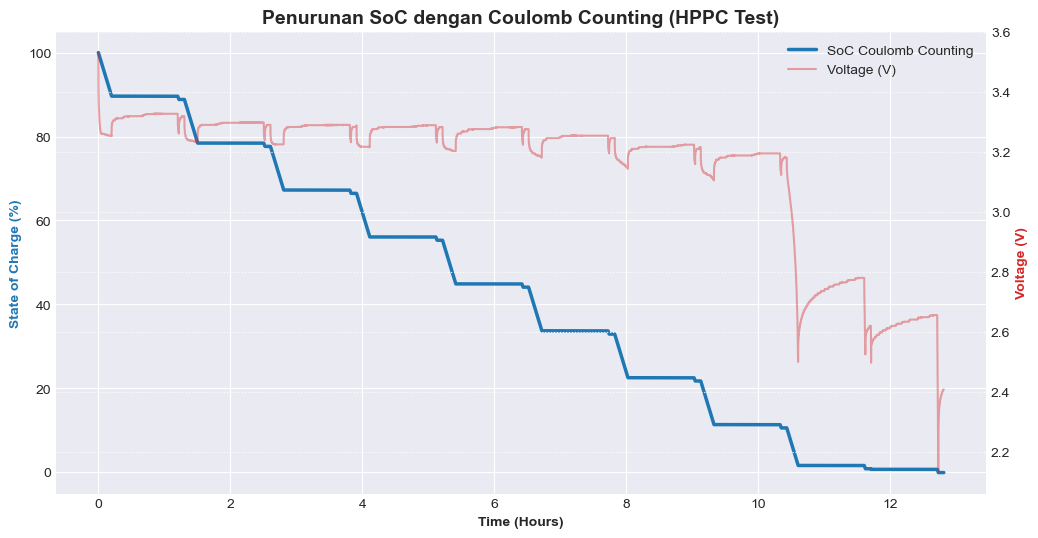

Sisa SoC Terakhir di Coulomb Counting (HPPC): -0.10%


In [2]:
# Load Data HPPC
df_hppc = load_zke_data("hppc (loop10x).csv")

# Kapasitas Total Aktual saat tes HPPC
Q_hppc_Ah = 21.13 

# Hitung selisih waktu antar baris (delta t) dalam detik
dt_hppc = df_hppc['Time(S)'].diff().fillna(0)

# Rumus Coulomb Counting (Akumulasi Arus x Waktu) -> dikonversi ke Ah (dibagi 3600)
df_hppc['Ah_Discharged'] = (df_hppc['Cur(A)'] * dt_hppc / 3600).cumsum()

# Hitung SoC (%)
df_hppc['SoC_CC (%)'] = (1.0 - (df_hppc['Ah_Discharged'] / Q_hppc_Ah)) * 100

# PLOT HASIL HPPC
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_hppc['Time(S)']/3600, df_hppc['SoC_CC (%)'], color='tab:blue', linewidth=2.5, label='SoC Coulomb Counting')
ax1.set_xlabel('Time (Hours)', fontweight='bold')
ax1.set_ylabel('State of Charge (%)', fontweight='bold', color='tab:blue')
ax1.set_title('Penurunan SoC dengan Coulomb Counting (HPPC Test)', fontweight='bold', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(df_hppc['Time(S)']/3600, df_hppc['Vol(V)'], color='tab:red', alpha=0.4, label='Voltage (V)')
ax2.set_ylabel('Voltage (V)', fontweight='bold', color='tab:red')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.grid(True, linestyle=':')
plt.show()

print(f"Sisa SoC Terakhir di Coulomb Counting (HPPC): {df_hppc['SoC_CC (%)'].iloc[-1]:.2f}%")

### 2. Uji Coulomb Counting pada Data Dynamic Profiling (Beban Rumah)
Pada tes beban acak ini, kapasitas yang berhasil dikuras alat adalah **20.81 Ah**. 
Di sinilah kita akan melihat kelemahan Coulomb Counting. Jika beban sangat fluktuatif, *error* pembacaan waktu dan arus akan menumpuk (*drifting*).

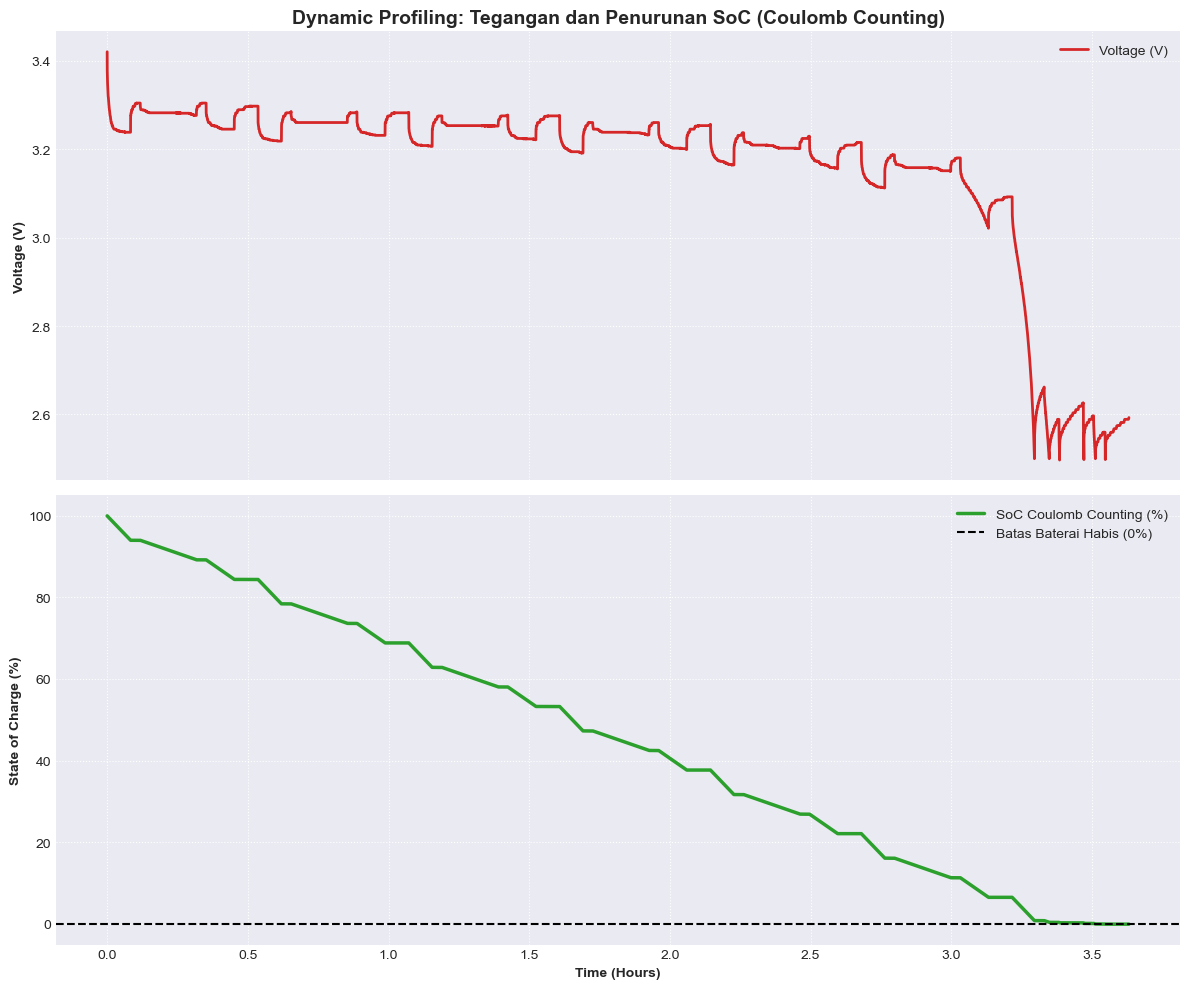

🚨 ANALISIS ERROR COULOMB COUNTING 🚨
Kapasitas Baterai Referensi : 20.81 Ah
Total Arus Terkuras (CC)    : 20.8375 Ah
Sisa SoC Terakhir (CC)      : -0.13%
KESIMPULAN UNTUK SKRIPSI:
Terbukti bahwa metode Coulomb Counting mengalami 'Drifting'.
Meskipun alat sudah memutus arus karena baterai habis (2.50V),
rumus Coulomb Counting justru bablas menunjukkan angka minus (di bawah 0%).
Ini membuktikan BMS konvensional tidak andal untuk profil beban dinamis.


In [3]:
# Load Data Dynamic
df_dyn = load_zke_data("Dynamic Profiling (Urban Load).csv")

# Kapasitas Total Aktual saat tes Dynamic (Dari hasil rekaman)
Q_dyn_Ah = 20.81

# Hitung selisih waktu (dt)
dt_dyn = df_dyn['Time(S)'].diff().fillna(0)

# Rumus Coulomb Counting
df_dyn['Ah_Discharged'] = (df_dyn['Cur(A)'] * dt_dyn / 3600).cumsum()
df_dyn['SoC_CC (%)'] = (1.0 - (df_dyn['Ah_Discharged'] / Q_dyn_Ah)) * 100

# PLOT HASIL DYNAMIC
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 10))

time_hrs = df_dyn['Time(S)']/3600

# Plot 1: Arus dan Tegangan
ax1.plot(time_hrs, df_dyn['Vol(V)'], color='tab:red', label='Voltage (V)', linewidth=2)
ax1.set_ylabel('Voltage (V)', fontweight='bold')
ax1.set_title('Dynamic Profiling: Tegangan dan Penurunan SoC (Coulomb Counting)', fontweight='bold', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':')

# Plot 2: SoC Coulomb Counting
ax2.plot(time_hrs, df_dyn['SoC_CC (%)'], color='tab:green', linewidth=2.5, label='SoC Coulomb Counting (%)')
# Tambahkan Garis Batas 0% untuk melihat Error
ax2.axhline(0, color='black', linestyle='--', label='Batas Baterai Habis (0%)')
ax2.set_xlabel('Time (Hours)', fontweight='bold')
ax2.set_ylabel('State of Charge (%)', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, linestyle=':')

plt.tight_layout()
plt.show()

print("="*50)
print(f"🚨 ANALISIS ERROR COULOMB COUNTING 🚨")
print("="*50)
print(f"Kapasitas Baterai Referensi : {Q_dyn_Ah} Ah")
print(f"Total Arus Terkuras (CC)    : {df_dyn['Ah_Discharged'].iloc[-1]:.4f} Ah")
print(f"Sisa SoC Terakhir (CC)      : {df_dyn['SoC_CC (%)'].iloc[-1]:.2f}%")
print("="*50)
if df_dyn['SoC_CC (%)'].iloc[-1] < 0:
    print("KESIMPULAN UNTUK SKRIPSI:")
    print("Terbukti bahwa metode Coulomb Counting mengalami 'Drifting'.")
    print("Meskipun alat sudah memutus arus karena baterai habis (2.50V),")
    print("rumus Coulomb Counting justru bablas menunjukkan angka minus (di bawah 0%).")
    print("Ini membuktikan BMS konvensional tidak andal untuk profil beban dinamis.")